# Debut

In [290]:
def random_float(min=0, max=9):
    import random
    entier = random.randint(min, max)
    float_ = random.random()
    return entier+float_

In [291]:
class Position():
    def __init__(self, longitude, lattitude):
        self.longitude = longitude
        self.lattitude = lattitude
    def __str__(self):
        return "(lon:%s lat:%s)"%(self.longitude, self.lattitude)


# 1) Logger

In [398]:
class Logger():
    def __init__(self, path, bufferlength=1, separator="\n", mode="a"):
        import os
        if os.path.exists(path) :
            msg = "Attention : vous allez utiliser un fichier existant !"
            print (msg)
            if (mode != "a"):
                raise msg
        self.path         = path
        self.logs         = []
        self.bufferlength = bufferlength
        self.separator    = separator

    def clean_msg(self, msg):
        msg = str(msg)
        if msg[-1] != "\n": 
            msg = msg + "\n"
        return msg
    
    def log(self, msg):
        msg = self.clean_msg(msg)
        import datetime
        msg=str(datetime.datetime.now().isoformat())+","+msg
        self.logs.append(msg)
        if self.bufferlength < len(self.logs):
            self.write_to_disk()
    
    def write_to_disk(self):
        with open(self.path, "a") as f:
            f.writelines(self.logs)
        self.logs= []
    
    def __del__(self):
        self.write_to_disk()
                

In [399]:
def get_random_position():
    return Position(random_float(), random_float())

# 2) Velo

In [400]:
class Velo:
    nb_d_instance =0
    def __init__(self):
        import random
        Velo.nb_d_instance += 1
        self.id             = "velo_%s"%(Velo.nb_d_instance)
        self.performance    = random.random()
    def update_performance(self):
        import numpy as np
        self.performance = np.random.normal(0.75, 0.2)

# 3) Trajet

In [401]:
class Trajet():
    def __init__(self, position_depart, position_arrivee):
        self.depart      = position_depart
        self.destination = position_arrivee
        self.set_position(position_depart)
        self.set_distance() 
        self.set_pas()
        self.avancee_minimale    = 1
        
    def set_position(self, position):
        self.longitude   = position.longitude
        self.lattitude   = position.lattitude
        self.position    = position
        
    def set_pas(self):
        delta_longitude    = self.destination.longitude  - self.longitude
        delta_lattitude    = self.destination.lattitude  - self.lattitude
        self.pas_longitude = delta_longitude / float(10)
        self.pas_lattitude = delta_lattitude / float(10)
        
    def set_distance(self):
        import math
        delta_longitude = self.destination.longitude  - self.longitude
        delta_lattitude = self.destination.lattitude  - self.lattitude
        distance        = math.sqrt(math.pow(delta_longitude, 2) + math.pow(delta_lattitude, 2))
        self.distance   = distance
        
    def next_position(self):
        self.set_distance() 
        if self.distance < self.avancee_minimale:
            self.set_position(self.destination)
            return self.destination
        else:
            new_longitude   = self.longitude + self.pas_longitude
            new_latitude    = self.lattitude + self.pas_lattitude
            new_position    = Position(new_longitude, new_latitude)
            self.set_position(new_position)
            return new_position

# 4) Decaux

In [402]:
class JcDecaux():
    def __init__(self, largeur=10, hauteur=10):
        self.largeur = largeur
        self.hauteur = hauteur
        self.reseau = []
        for lattitude in range(self.largeur):
            for longitude in range(self.hauteur):
                emplacement = Position(lattitude, longitude)
                new_station = Station(emplacement)
                self.reseau.append(new_station)
                
    def get_closest_station(self, position):
        nb_ligne = round(position.lattitude)
        nb_col   = round(position.longitude)
        
        indice   =  (nb_ligne * self.largeur) + (nb_col )
        try:
            closest  = self.reseau[int(indice)]
        except:
                closest  = self.reseau[-1]
        return closest
    

    def filtrer_le_reseau(self, function_de_test):
        """
        Renvoie les stations qui passe le test.
        
        Parameters:
            function de test : lambda function
        Return:
            list
        
        """
        return list(filter(function_de_test, self.reseau))
    def nb_station_passant_le_test(self, function):
        r = self.filtrer_le_reseau(function)
        return len(r)
    
    def nombre_de_stations(self):
        return len(self.reseau)
    
    def nombre_de_velos(self):
        return sum(map(lambda x: x.nb_de_velos(),self.reseau))
    
    def nombre_de_stations_pleine(self):
        test  = lambda station: station.nb_bornes == len(station.velos)
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_avec_velo(self):
        test = lambda x: x.has_velo()
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_vide(self):
        test  = lambda station: not station.has_velo()
        return self.nb_station_passant_le_test(test)

    def __str__(self):
        return """
                Nb de stations           : %s 
                Nb de vélos              : %s 
                Nb de stations avec vélo : %s 
                Nb de stations pleines   : %s
                Nb de stations vides     : %s
        """%(self.nombre_de_stations(),
             self.nombre_de_velos(),
             self.nombre_de_stations_avec_velo(),
             self.nombre_de_stations_pleine(),
             self.nombre_de_stations_vide())
    
    def nombre_de_velos_sous_performants(self, seuil=0.5):
        r = map(lambda station: station.nb_velo_under_perf(seuil), self.reseau)
        return sum(list(r))
    

# 5) Station

In [403]:
class Station:
    nb_d_instance =0
    station_logger=Logger("./stations.csv")
    def __init__(self, position):
        import random
        Station.nb_d_instance +=1
        NB_BORNES_POSSIBLES = [5,10,15,20,30]
        self.position       = position
        self.nb_bornes      = random.choice(NB_BORNES_POSSIBLES)
        self.velos          = [Velo() for i in range(self.nb_bornes)]
        self.id             = Station.nb_d_instance
    
    def nb_de_velos(self):
        return len(self.velos)

    def has_empty_place(self):
        return len(self.velos) < self.nb_bornes

    def has_velo(self):
        return 0 < len(self.velos)
    def log(self, message):
        message="station_%s : %s"%(self.id, message)
        Station.station_logger.log(message)
        
    def deposer_un_velo(self, velo):
        if self.has_empty_place():
            velo.update_performance()
            self.velos.append(velo)
            self.log("recupere le velo %s"%velo.id)
            return True
        else:
            self.log("complete")
            return False
    def prendre_un_velo(self):
        if self.has_velo():
            velo = self.velos.pop()
            self.log("donne le velo %s"%velo.id)
            return velo
        else:
            self.log("vide.")
            return False

    def nb_velo_under_perf(self, seuil_de_performance=0.5):
        test = lambda velo: velo.performance < seuil_de_performance
        return len(list(filter(test, self.velos)))
        

Attention : vous allez utiliser un fichier existant !


# 6) Cycliste

In [404]:
class Cycliste:
    nb_d_instance =0
    cycliste_logger= Logger("./cyclistes.csv")
    def __init__(self, position_home, position_travail):
        import random
        import numpy as np
        Cycliste.nb_d_instance +=1
        self.id           = Cycliste.nb_d_instance
        self.home         = position_home
        self.travail      = position_travail
        self.est_en_route = False
        self.position     = position_home
        self.destination  = position_travail
        self.sur_velo     = False
        self.velo         = False
        self.set_next_trajet()
        self.sexe         = random.choice(["H", "F"])
        self.age          = random.choice(range(15,85))
        self.sportivite   = np.random.normal(2, 2)
        
        
        
    def est_a_la_maison(self):
        return self.position == self.home
    def est_au_travail(self):
        return self.position == self.travail
    def est_arrive(self):
        return self.position == self.destination
    
    def log(self, message):
        message="cycliste_%s : %s"%(self.id, message)
        Cycliste.cycliste_logger.log(message)
        
    def trouve_velo(self):
        limite = 10
        while not self.sur_velo and 0 < limite :
            limite         = limite - 1
            station_proche = reseau.get_closest_station(self.position)
            velo           = station_proche.prendre_un_velo()
            self.log("essaie station : %s "%station_proche.id)
            self.position  = station_proche.position 
            if velo:
                self.log("trouve velo %s sur station %s"%(velo.id, station_proche.id))
                self.sur_velo = True
                self.velo     = velo
                self.set_next_trajet()
                
    def rendre_velo(self):
        limite = 10
        while self.sur_velo and 0 < limite :
            limite         = limite - 1
            station_proche = reseau.get_closest_station(self.position)
            velo_rendu     = station_proche.deposer_un_velo(self.velo)
            self.log("essaie de rendre sur la station : %s "%station_proche.id)
            self.position  = station_proche.position 
            if velo_rendu:
                self.log( "velo rendu sur la station sur : %s"%station_proche.id)
                self.sur_velo = False
                self.velo     = False
                #self.set_next_trajet()
                
    def set_next_trajet(self):
        if self.est_a_la_maison():
            self.log("next trajet = travail")
            self.destination = self.travail
        if self.est_au_travail():
            self.log("next trajet = maison")
            self.destination = self.home
        self.trajet = Trajet(self.position, self.destination)
    
    
    def avancer(self):
        if self.sur_velo:
            self.log( "est sur un velo")
            if self.est_arrive():
                self.log( "est arrive")
                self.set_next_trajet()
                self.rendre_velo()
            else:
                self.position = self.trajet.next_position()
                self.log( "va a la prochaine position : %s "%self.position.__dict__)
        else:
            self.log( "va chercher un velo")
            self.trouve_velo()
            
        

Attention : vous allez utiliser un fichier existant !


In [405]:
class Ville:
    def __init__(self, nb_de_cyclistes):
        self.cyclistes = [Cycliste(get_random_position(), get_random_position()) for i in range(nb_de_cyclistes)]
        
    def reveil(self):
        list(map(lambda cycliste : cycliste.avancer(), self.cyclistes))
        

# 7) Algo

In [406]:
reseau = JcDecaux(10,10)


In [407]:
print(reseau)


                Nb de stations           : 100 
                Nb de vélos              : 1490 
                Nb de stations avec vélo : 100 
                Nb de stations pleines   : 100
                Nb de stations vides     : 0
        


In [408]:
reseau.nombre_de_velos()

1490

In [409]:
paris = Ville(3)


In [410]:
for i in range(10):
    paris.reveil()

In [412]:
!pwd

/home/spark/formation_python


In [411]:
!cat cyclistes.csv

cycliste_4 : next trajet = travail
cycliste_5 : next trajet = travail
cycliste_6 : next trajet = travail
cycliste_4 : va chercher un velo
cycliste_4 : essaie station : 165 
cycliste_4 : trouve velo velo_8935 sur station 165
cycliste_5 : va chercher un velo
cycliste_5 : essaie station : 187 
cycliste_5 : trouve velo velo_9280 sur station 187
cycliste_6 : va chercher un velo
cycliste_6 : essaie station : 183 
cycliste_6 : trouve velo velo_9195 sur station 183
cycliste_4 : est sur un velo
cycliste_4 : va a la prochaine position : {'longitude': 5.7483317800289395, 'lattitude': 3.9157684496334415} 
cycliste_5 : est sur un velo
cycliste_5 : va a la prochaine position : {'longitude': 7.567430296450751, 'lattitude': 5.675058100031086} 
cycliste_6 : est sur un velo
cycliste_6 : va a la prochaine position : {'longitude': 7.2553105717618385, 'lattitude': 1.9885839291873988} 
cycliste_4 : est sur un velo
cycliste_4 : va a la prochaine position : {'longitude': 5.496663560057879, 'lattitude': 3.8315

In [366]:
!cat stations.csv

station_27 : donne le velo velo_6655
station_165 : donne le velo velo_8935
station_187 : donne le velo velo_9280
station_183 : donne le velo velo_9195
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete
station_134 : complete


In [311]:
if False:
    path_to_cyclistes = "./cyclistes.csv"
    logger_ = Logger(path_to_cyclistes)
    infos_voulues = ["id", "sexe", "sportivite", "age", "sur_velo"]
    to_write      = ",".join(infos_voulues)
    logger_.log(to_write)
    for cycliste in paris.cyclistes:
        dico          = cycliste.__dict__        
        infos         = [str(dico[voulue]) for voulue in infos_voulues]
        to_write      = ",".join(infos)
        logger_.log(to_write)


Attention : vous allez utiliser un fichier existant !


# Exemple de dataFrame pandas

In [313]:
logger_.write_to_disk()


In [308]:
import pandas as pd

In [309]:
dico = {}
for i in range(12):
    seuil       = float(i/10)
    nb_velo     = test_reseau.nombre_de_velos_sous_performants(seuil)
    dico[seuil] = nb_velo

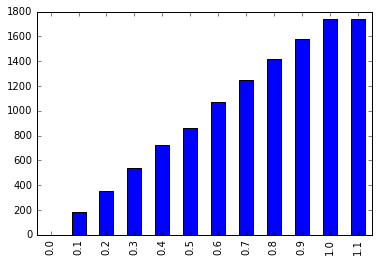

In [310]:
%matplotlib inline
pd.DataFrame(dico, index=range(12)).T[0].plot(kind='bar')